# Compute Diffusivity Position Dependent with in-house MSD

## Luca Sagresti 

### V0 14/11/2019 Initial script (Hard coding) 

### V1 15/11/2019 Modified to take into account jump of PBC in box

In [97]:
import sys; from sys import argv

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib as mpl

import MDAnalysis as mda

%matplotlib inline

mpl.rcParams['figure.dpi']=100
mpl.rcParams['figure.titlesize']=20
mpl.rcParams['axes.facecolor']='white'        
mpl.rcParams['lines.linewidth']=2.0
mpl.rcParams['axes.linewidth']=2.0
mpl.rcParams['xtick.major.pad']=6
mpl.rcParams['ytick.major.pad']=6
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['axes.titlesize']=18
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['axes.grid']='True'
mpl.rcParams['axes.axisbelow']='line'
mpl.rcParams['legend.fontsize']=12

## Study of the 0025M concentration 

In [118]:
# File reading

# N.B. IT IS IMPORTANT TO IMPORT HERE THE TRAJECTORY UNWRAPPED WITH NO PBC JUMPS OTHERWISE LOCAL_MSD
# COULD BE WRONG COMPUTED 

# Path to the pdb file
pdb_file="/home/luca/AVOGADRO/09-07-10-32_0025M_elf_-0.22/5Ang_Sampling_0_10ns.pdb"

# Path to the pbc nojump xtc file (possible to do with gmx trjconv -pbc nojump just for the ions selected)
xtc_file="/home/luca/My_script/TRAJ/UNWRAPPED_0025M.xtc"

u=mda.Universe(pdb_file,xtc_file) 

box_lenghts=u.dimensions

z_dimension=box_lenghts[2]


In [119]:
# Space discretization

starting_position = 82.0 #argv[3] in Angstrom

ending_position = 62.0 #argv[4] in Angstrom

spacing = 4.0 #argv[5] in Angstrom

number_points = np.int(np.abs((ending_position-starting_position)/spacing))

z = np.linspace(starting_position,ending_position,number_points+1)

#print number_points


In [120]:
# Time discretization

#Compute the timestep between frames
Delta_t=u.trajectory[1].time-u.trajectory[0].time          #10 picoseconds

T=200 #picoseconds, window of time that could be setted as one of the inputs

N=np.int(T/Delta_t)

# Delay and shift definition

#Delay=10 #how many picoseconds you want to skip that could be setted as one of the inputs

#shift=np.int(Delay/Delta_t)

t=np.linspace(0,T,N)


In [121]:
# Import data from trajectories

z_coordinate_NAR=np.zeros(len(u.trajectory))

#NA_atoms=u.select_atoms("resname NA or resname NAR")

NAR_atoms=u.select_atoms("resname NAR")

m=0

for frm in u.trajectory[:]:

    z_coordinate_NAR[m]=NAR_atoms.positions[0,2]

    m+=1
    

In [122]:
# Definition of the function MSD to recall in the main (Modify in the case of insertion of a shift to avoid correlations)

def compute_msd(traj, starting, steps):
    
    msds = np.zeros(steps)
    
    for n in range(0,steps):
        
        diffs = traj[starting] - traj[starting+n]
        
        sqdist = np.square(diffs)
        
        msds[n] = sqdist
        
        #msds_std[i] = sqdist.std() to add if a more particles are taken into account

    return msds


In [123]:
# Run the main looping on the z interval and then on the z positions

msd_partial= np.zeros(N)

msd=np.zeros((N, len(z)-1))

msds = np.zeros(N)

for j in range (0,len(z)-1):
    
    count=0
    
    for i in range (0,len(z_coordinate_NAR)):

        N_Box=np.floor(z_coordinate_NAR[i]/z_dimension)
        
        if (z_dimension*N_Box+z[j+1]<=z_coordinate_NAR[i]<=z_dimension*N_Box+z[j] and i<len(z_coordinate_NAR)-N):
                        
            msd_partial[:]+=compute_msd(z_coordinate_NAR, i, N)
            
            count+=1
            
    # Insert a check that count cannot be zero !!!!

    msd[:,j]=msd_partial[:]/float(count)


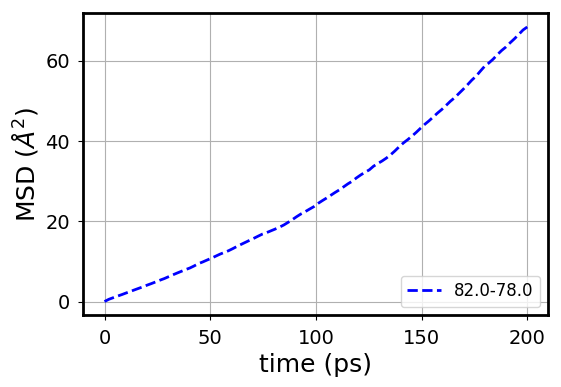

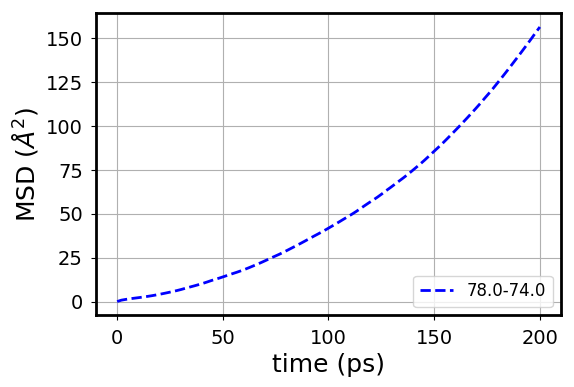

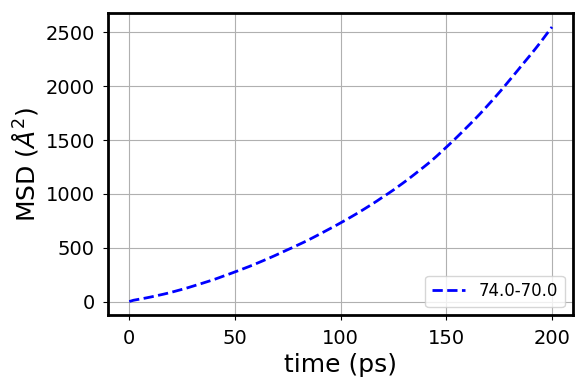

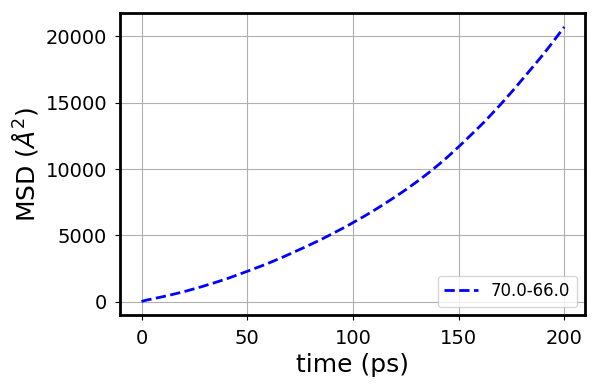

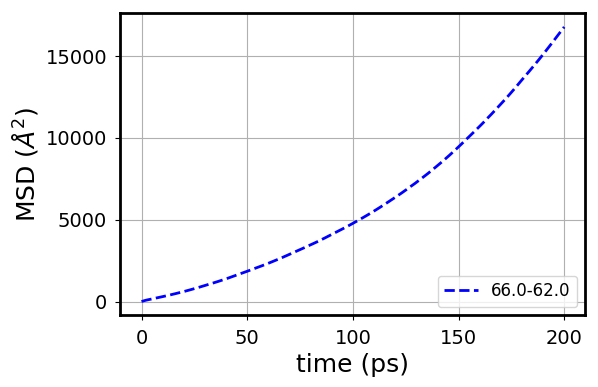

In [124]:
for k in range (0,len(z)-1):

    plt.plot(t, msd[:,k], 'b--', linewidth=2.0, label='%.1f-%.1f' %(z[k], z[k+1]))
    plt.legend(loc='lower right')
    plt.xlabel('time (ps)')
    plt.ylabel('MSD ($\AA^2$)')
    plt.show()
    

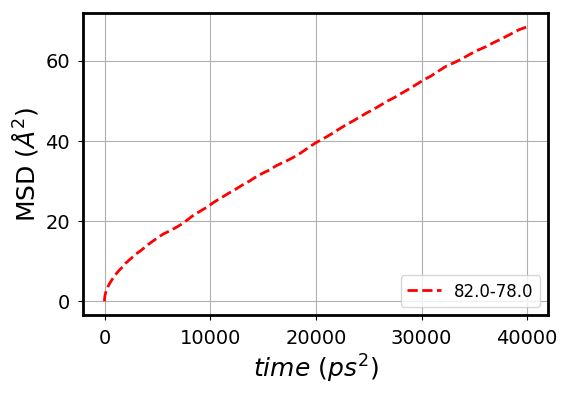

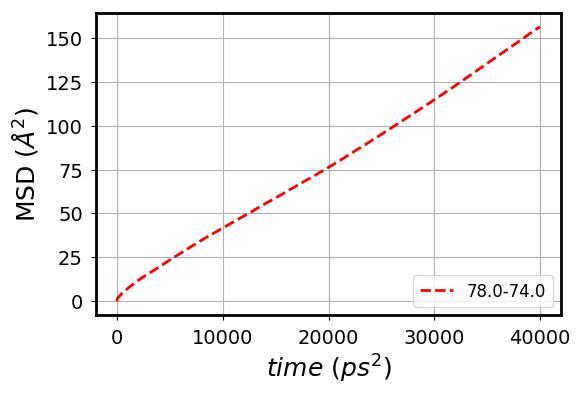

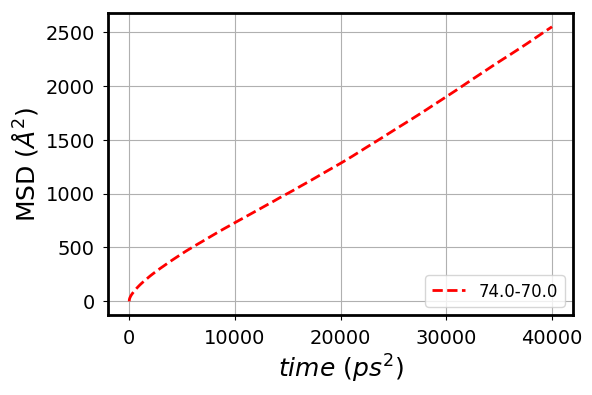

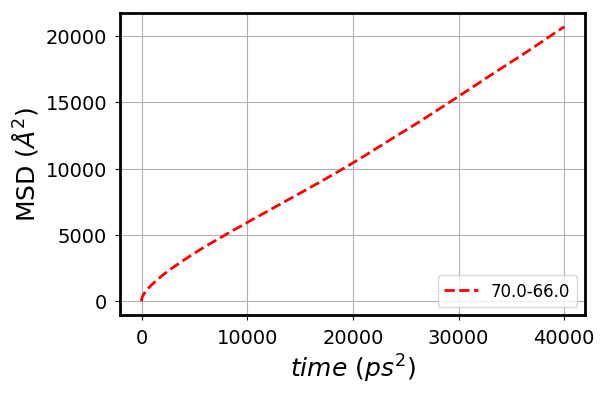

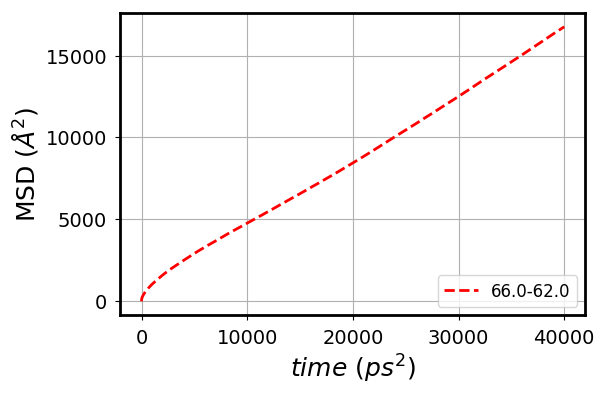

In [125]:
for k in range (0,len(z)-1):

    plt.plot(t*t, msd[:,k], 'r--', linewidth=2.0, label='%.1f-%.1f' %(z[k], z[k+1]))
    plt.legend(loc='lower right')
    plt.xlabel('$time$ ($ps^2$)')
    plt.ylabel('MSD ($\AA^2$)')
    plt.show()
    

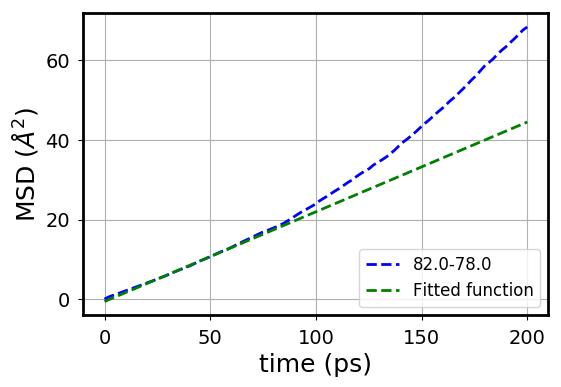

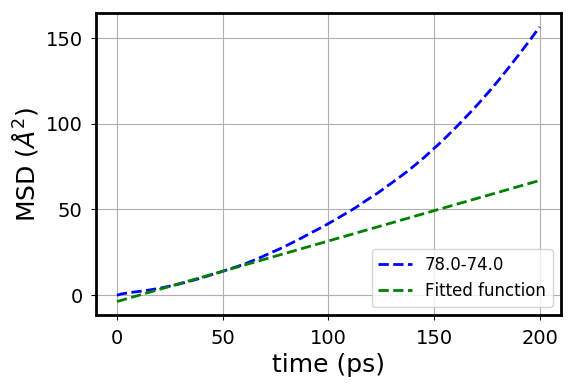

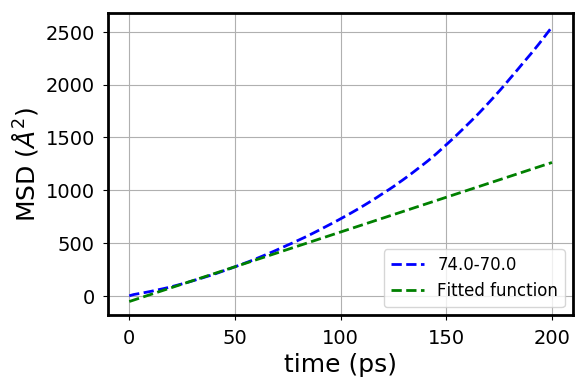

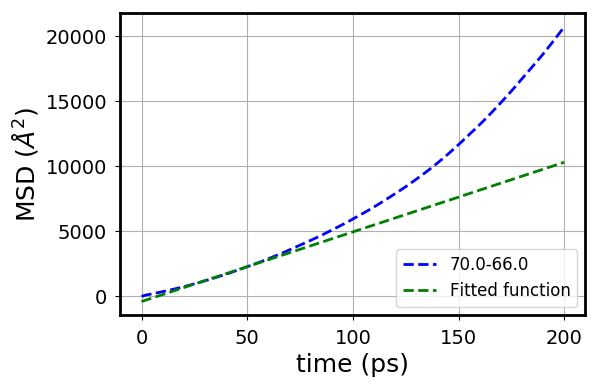

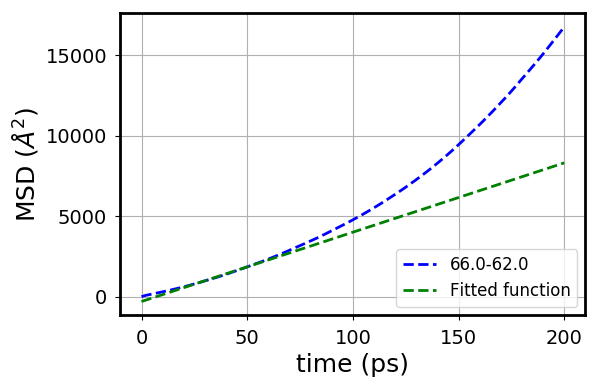

In [126]:
from scipy.optimize import curve_fit

def linearfit(x, m, q):
        return m*x + q

def parabolicfit(x, a, b):
        return a*x*x+b*x

diff_parabolic = np.zeros(len(z)-1)

diff_linear_0025M = np.zeros(len(z)-1)

Discarded_initial_time = 20 # ps

Fit_until_time = 60 # ps

Discarded_initial_frames = np.int(Discarded_initial_time / Delta_t) 

Fit_until_frames = np.int(Fit_until_time / Delta_t)


for j in range (0,len(z)-1):

        params_lin, params_covariance_lin = curve_fit(linearfit,t[Discarded_initial_frames:Fit_until_frames],msd[Discarded_initial_frames:Fit_until_frames,j])
        #print(params, params_covariance)

#        params_pa, params_covariance_pa = curve_fit(parabolicfit,t,msd[:,j])
        #print(params_pa, params_covariance_pa)

#        velocity_parabolic = np.sqrt(params_pa[0]) * 10000 # cm/s
#        diff_parabolic[j] = (params_pa[1] / 2) / 10000 # cm^2/s
 
        diff_linear_0025M[j] = (params_lin[0] / 2 ) / 10000 # cm^2/s
    
        plt.plot(t, msd[:,j], 'b--', linewidth=2.0, label='%.1f-%.1f' %(z[j], z[j+1]))
        plt.plot(t,linearfit(t,params_lin[0],params_lin[1]),'g--', label='Fitted function')
#        plt.plot(t,parabolicfit(t,params_pa[0],params_pa[1]),'r--',label='Fitted parabolic function')
        plt.legend(loc='lower right')
        plt.xlabel('time (ps)')
        plt.ylabel('MSD ($\AA^2$)')
        plt.show()




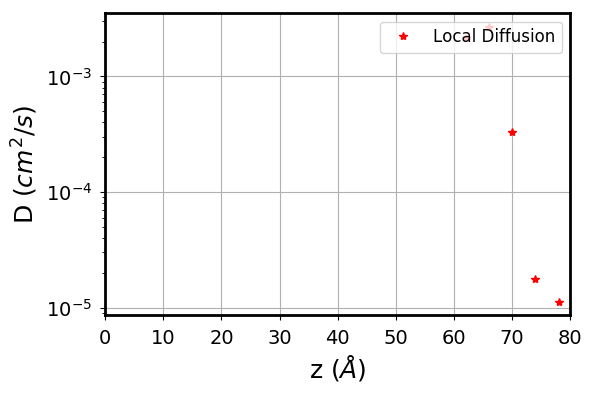

In [127]:
fig = plt.figure()
axes = fig.add_subplot(111)
plt.plot(z[1:],diff_linear_0025M, 'r*', label='Local Diffusion')
plt.legend(loc='upper right')
plt.xlabel('z ($\AA$)')
plt.ylabel('D ($cm^2/s$)')
plt.gca().set_yscale('log')
axes.set_xticks(np.arange(0, 90, 10))
#ax.set_yticks(numpy.arange(0, 1., 0.1))
plt.grid(True)
plt.show()

In [128]:
print diff_linear_0025M


[1.12802868e-05 1.76322524e-05 3.29302712e-04 2.67410372e-03
 2.15406990e-03]


## Study of the 1M concentration

In [129]:
# File reading

# N.B. IT IS IMPORTANT TO IMPORT HERE THE TRAJECTORY UNWRAPPED WITH NO PBC JUMPS OTHERWISE LOCAL_MSD
# COULD BE WRONG COMPUTED 

# Path to the pdb file
pdb_file="/home/luca/AVOGADRO/09-07-10-35_1M_elf_-0.22/5Ang_Sampling_0_10ns.pdb"

# Path to the pbc nojump xtc file (possible to do with gmx trjconv -pbc nojump just for the ions selected)
xtc_file="/home/luca/My_script/TRAJ/UNWRAPPED_1M.xtc"

u=mda.Universe(pdb_file,xtc_file) 

box_lenghts=u.dimensions

z_dimension=box_lenghts[2]


In [130]:
# Import data from trajectories

z_coordinate_NAR=np.zeros(len(u.trajectory))

#NA_atoms=u.select_atoms("resname NA or resname NAR")

NAR_atoms=u.select_atoms("resname NAR")

m=0

for frm in u.trajectory[:]:

    z_coordinate_NAR[m]=NAR_atoms.positions[0,2]

    m+=1
    

In [131]:
# Run the main looping on the z interval and then on the z positions

msd_partial= np.zeros(N)

msd=np.zeros((N, len(z)-1))

msds = np.zeros(N)

for j in range (0,len(z)-1):
    
    count=0
    
    for i in range (0,len(z_coordinate_NAR)):

        N_Box=np.floor(z_coordinate_NAR[i]/z_dimension)
        
        if (z_dimension*N_Box+z[j+1]<=z_coordinate_NAR[i]<=z_dimension*N_Box+z[j] and i<len(z_coordinate_NAR)-N):
                        
            msd_partial[:]+=compute_msd(z_coordinate_NAR, i, N)
            
            count+=1
            
    # Insert a check that count cannot be zero !!!!

    msd[:,j]=msd_partial[:]/float(count)


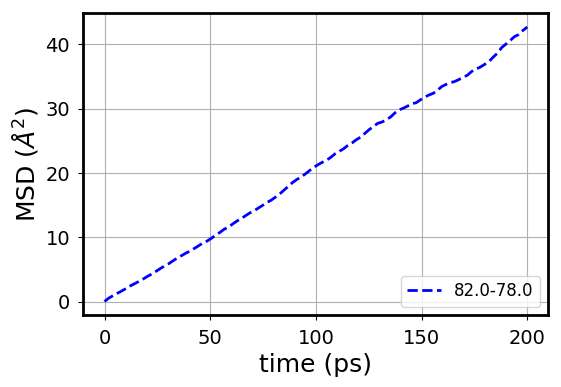

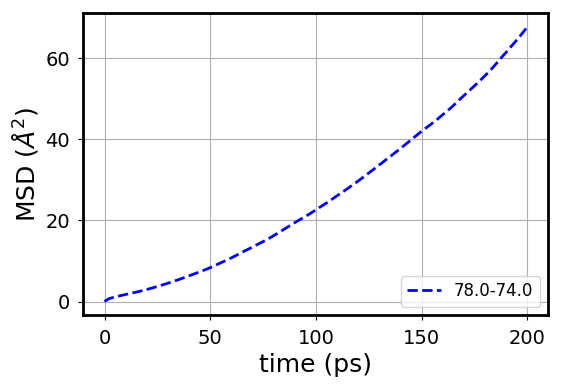

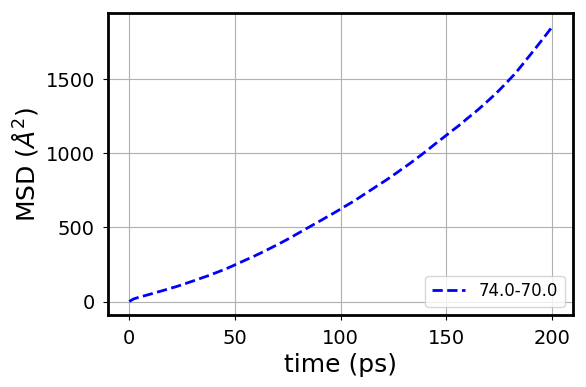

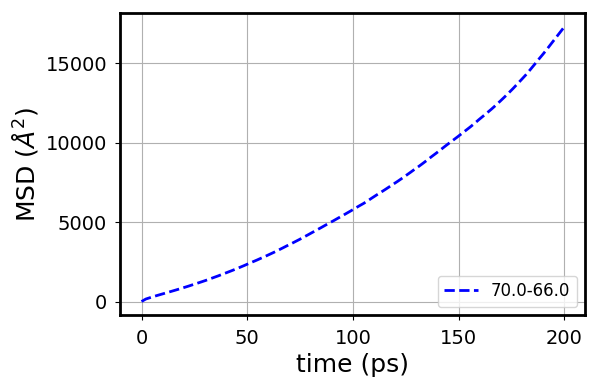

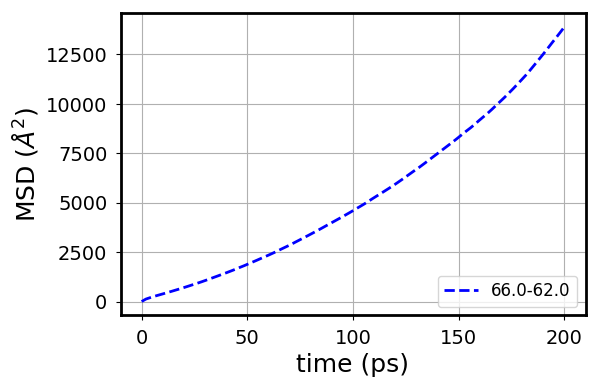

In [132]:
for k in range (0,len(z)-1):

    plt.plot(t, msd[:,k], 'b--', linewidth=2.0, label='%.1f-%.1f' %(z[k], z[k+1]))
    plt.legend(loc='lower right')
    plt.xlabel('time (ps)')
    plt.ylabel('MSD ($\AA^2$)')
    plt.show()
    

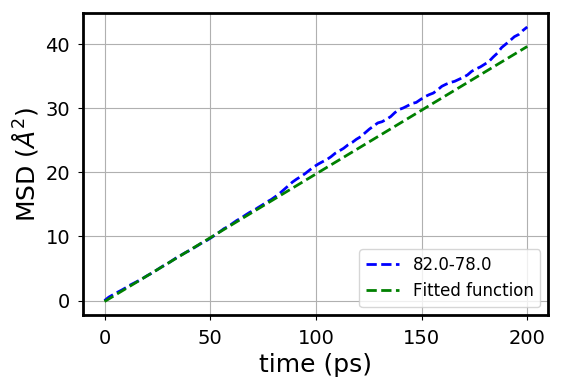

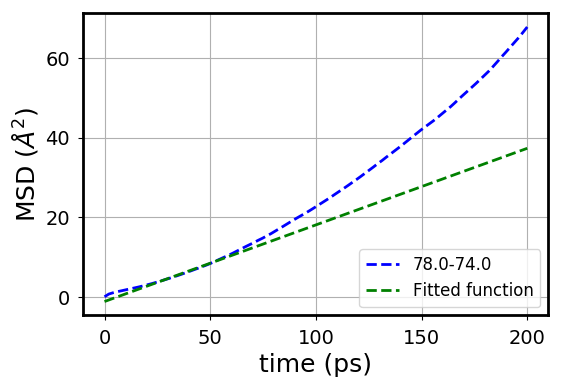

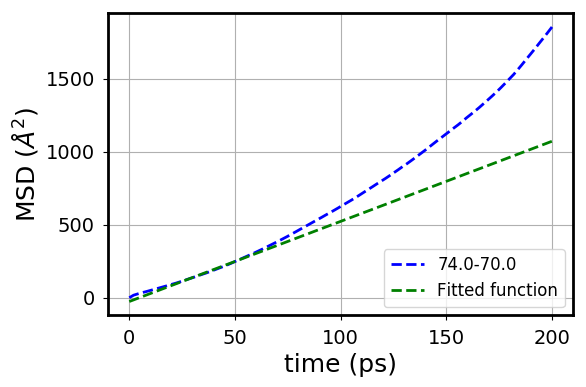

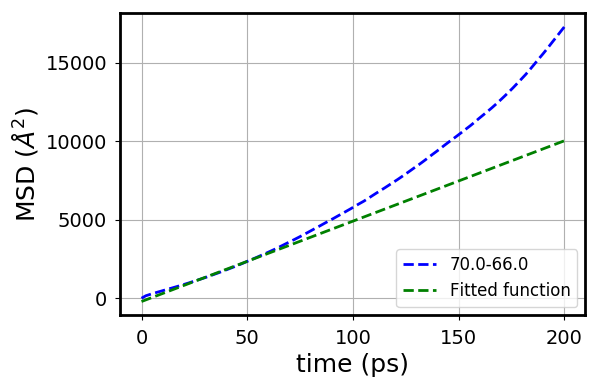

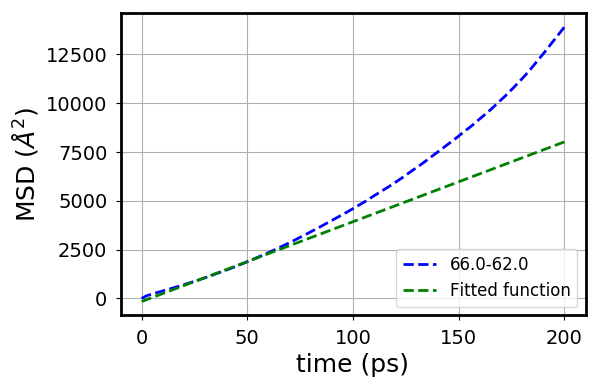

In [133]:
#def linearfit(x, m, q):
 #       return m*x + q

#def parabolicfit(x, a, b):
  #      return a*x*x+b*x

diff_parabolic = np.zeros(len(z)-1)

diff_linear_1M = np.zeros(len(z)-1)

Discarded_initial_time = 20 # ps

Fit_until_time = 60 # ps

Discarded_initial_frames = np.int(Discarded_initial_time / Delta_t) 

Fit_until_frames = np.int(Fit_until_time / Delta_t)


for j in range (0,len(z)-1):

        params_lin, params_covariance_lin = curve_fit(linearfit,t[Discarded_initial_frames:Fit_until_frames],msd[Discarded_initial_frames:Fit_until_frames,j])
        #print(params, params_covariance)

#        params_pa, params_covariance_pa = curve_fit(parabolicfit,t,msd[:,j])
        #print(params_pa, params_covariance_pa)

#        velocity_parabolic = np.sqrt(params_pa[0]) * 10000 # cm/s
#        diff_parabolic[j] = (params_pa[1] / 2) / 10000 # cm^2/s
 
        diff_linear_1M[j] = (params_lin[0] / 2 ) / 10000 # cm^2/s
    
        plt.plot(t, msd[:,j], 'b--', linewidth=2.0, label='%.1f-%.1f' %(z[j], z[j+1]))
        plt.plot(t,linearfit(t,params_lin[0],params_lin[1]),'g--', label='Fitted function')
#        plt.plot(t,parabolicfit(t,params_pa[0],params_pa[1]),'r--',label='Fitted parabolic function')
        plt.legend(loc='lower right')
        plt.xlabel('time (ps)')
        plt.ylabel('MSD ($\AA^2$)')
        plt.show()




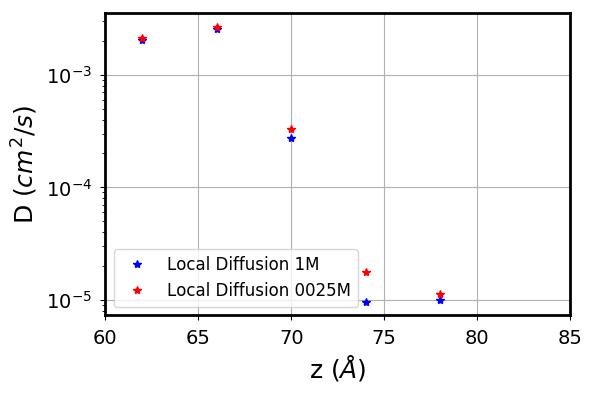

In [134]:
fig = plt.figure()
axes = fig.add_subplot(111)
plt.plot(z[1:],diff_linear_1M, 'b*', label='Local Diffusion 1M')
plt.plot(z[1:],diff_linear_0025M, 'r*', label='Local Diffusion 0025M')
plt.legend(loc='lower left')
plt.xlabel('z ($\AA$)')
plt.ylabel('D ($cm^2/s$)')
plt.gca().set_yscale('log')
axes.set_xticks(np.arange(60, 90, 5))
#ax.set_yticks(numpy.arange(0, 1., 0.1))
plt.grid(True)
plt.show()

In [135]:
print diff_linear_1M

[9.95147863e-06 9.62091335e-06 2.74147352e-04 2.55791000e-03
 2.04155201e-03]


In [136]:
print diff_linear_0025M

[1.12802868e-05 1.76322524e-05 3.29302712e-04 2.67410372e-03
 2.15406990e-03]
